In [1]:
import numpy as np
import scipy.io as sio

import matplotlib.pyplot as plt
# from modelfunctions import *
%matplotlib inline

# Obtaining Data

In [2]:
control = 0 # 0: sinthetic; 1: real
mycmap = 'seismic'
np.random.seed(51)

In [3]:
def show_fft_image(img_fft, shift = True, save = False , name = 'my_name.png'):
    
    img_fftabs = img_fft
    if type(img_fft[0,0]) == np.complex128:
        img_fftabs = np.abs(img_fft)
    
    if shift:
        img_fftabs = np.fft.fftshift(img_fftabs)
    plt.imshow(img_fftabs, cmap=mycmap)
    plt.grid('off')
    
    if save:
        plt.savefig(name, format= 'png')

In [4]:
def phi(U,a,b,c,e,f):
    try:
        u = U[:,0]
        v = U[:,1]
    except IndexError:
        u = U[0]
        v = U[1]
    return np.exp(2*np.pi**2*(a*v**2 + b*u**2 - c*u*v)/(4.*a*b-c**2) -2*np.pi*1j*(f*v+e*u))

def psi(x,y, a, b, c, e, f):
    invSigma = np.array([[-2.0*a,-c],[-c, -2.0*b]]).reshape(2,2)
#     print(invSigma)
    
    if not isinstance(x,np.ndarray):
        xx = np.array([x-e,y-f])
    else:
        xx = np.stack([x-e,y-f], axis = 1).T
    
    return np.exp(-xx.T.dot(invSigma).dot(xx))

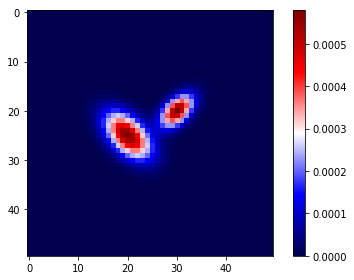

In [5]:
if control:
    path = '/home/lerko/Dataset_ALMA'
    fileName = 'Dataset_ALMA_11_07_17.mat'
    fullPath = path +'/' + fileName
    data = sio.loadmat(fullPath)
    imageName = 'name_HLTau'
    img = data['Dataset'][imageName][0,0]['size_128x128'][0,0]
    IMAGE_SIZE_X, IMAGE_SIZE_Y = img.shape
    x = np.arange(IMAGE_SIZE_X)
    y = np.arange(IMAGE_SIZE_Y)
    
    print(data['Dataset'].dtype)
elif not control:
    x = np.arange(50)
    y = np.arange(50)
    
    s1 = np.array([20,10])
    s2 = np.array([20,10])
    s12 = np.array([10,-5])

    a = -0.5*s2/(s1*s2-s12**2)
    b = -0.5*s1/(s1*s2-s12**2)
    c = s12/(s1*s2-s12**2)
#     invSigma = np.array([[-2.*a,-c],[-c, -2.*b]])
#     print(np.linalg.inv(invSigma))

    e = np.array([50,40])/2
    f = np.array([40,60])/2
    numberOfBasis = e.shape[0]
    img = np.zeros((x.shape[0],y.shape[0]))

    for i in range(x.shape[0]):
        for j in range(y.shape[0]):
            for k in range(numberOfBasis):
                img[i,j] = img[i,j] + psi(x[i],y[j],a[k],b[k],c[k],e[k],f[k])
    IMAGE_SIZE_X, IMAGE_SIZE_Y = img.shape

plt.imshow(0.00058*img/np.max(img), cmap=mycmap)
plt.colorbar()
plt.tight_layout()
# plt.savefig('{}.png'.format(imageName), format='png')

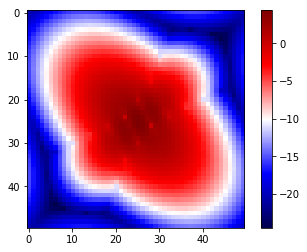

In [6]:
# Calculate the spectrum
img_fft= np.fft.fft2(img)
FTgshift = np.fft.fftshift(img_fft)

plt.imshow(np.log(np.abs(FTgshift)), cmap=mycmap)
plt.colorbar()

## Creating sampling mask

For creating the sampling mask, we have made a u,v representations based on the antennas disposition. This is because, if the antennas disposition is random, the measures are not completely random. The Measurements positions are defined by the interferometry physics.

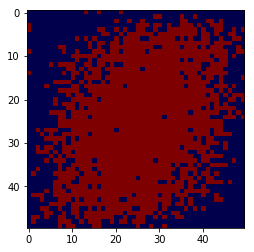

In [7]:
from masking import *

## Parameters
B_max = 1
antennas = 60
typeArray = 'URA'
sigma = B_max/6.0

lambda_phy=3*10**(-6); #(km)
H0=10; #(deg)
delta0=-30; #(deg)
Lat=34.05;  #(deg) Lat VLA

## Masking function returns the mask
mask = createSpectrumMasking(B_max,antennas,typeArray,sigma, lambda_phy, H0, delta0, Lat, N1 = IMAGE_SIZE_X, N2 = IMAGE_SIZE_Y)
show_fft_image(mask)

## Sampling

Variable measurements are the 2D representation for the measurements. U are the positions in the u,v spaces, i.e., U[0] = u, U[1] = v. Finally, V is the visibility function.

Percentage of measurements: 57.8


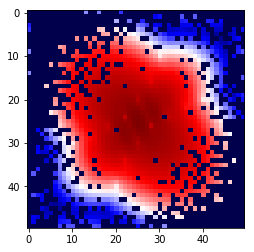

In [8]:
measurements,Uobs,Vobs = UVCreator(img_fft,mask)

measurements_abs = np.log(np.abs(measurements)+1e-12)
show_fft_image(measurements_abs)

p = 100*Uobs.shape[0]/(measurements.shape[0]*measurements.shape[1]) 
print('Percentage of measurements: %s' % p)

In [9]:
print('Getting indexes (u,v)->i..', end='')
mask_vect = mask.reshape(-1)
mask_vect_index = np.where(mask_vect == 1)[0]
mask_vect_index2 = np.concatenate([mask_vect_index, mask_vect_index])
print('done.')

Getting indexes (u,v)->i..done.


# Model

### Fourier Matrix

In [10]:
import numpy as np
def DFT_matrix(N):
    i, j = np.meshgrid(np.arange(N), np.arange(N))
    omega = np.exp( -2 * np.pi * 1J / N )
    W = np.power( omega, i * j ) / np.sqrt(N)
    return W

Wizq = DFT_matrix(IMAGE_SIZE_X)
Wder = DFT_matrix(IMAGE_SIZE_Y)
W = np.kron(Wder.T,Wizq).T
print('Krockener product shape: {}'.format(W.shape))

Krockener product shape: (2500, 2500)


In [11]:
# plt.imshow(Kron.real)
# plt.colorbar()

In [12]:
# plt.imshow(W.real*W.real.T)
# plt.colorbar()

In [13]:
# plt.imshow(Kron.imag)
# plt.colorbar()

In [14]:
# plt.imshow(np.abs(Kron))
# plt.colorbar()

In [15]:
print('Separanting real and imaginary part...', end='')
Vrobs = Vobs[:,0]
Viobs = Vobs[:,1]
Vobs_concat = Vobs.reshape(-1, order='F')
print('done.')

Separanting real and imaginary part...done.


In [16]:
C = np.concatenate([np.eye(W.shape[0]), 1j*np.eye(W.shape[0])], axis=1)
print('C shape: {}'.format(C.shape))
V_concat = np.concatenate([img_fft.real.reshape(-1), img_fft.imag.reshape(-1)])[:,np.newaxis]
print('V concat shape: {}'.format(V_concat.shape))
W_new = np.matmul(W,C).real
I_concat = np.matmul(W_new,V_concat)

C shape: (2500, 5000)
V concat shape: (5000, 1)


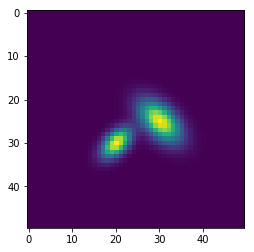

In [17]:
plt.imshow(I_concat.reshape(IMAGE_SIZE_Y, IMAGE_SIZE_X))

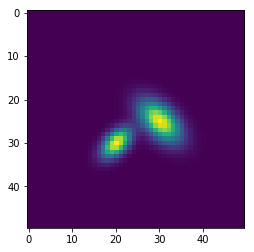

In [18]:
I = np.matmul(W,img_fft.reshape(-1))
plt.imshow(I.real.reshape(IMAGE_SIZE_Y, IMAGE_SIZE_X))

## Kernels

In [19]:
import gpflow
import tensorflow as tf

/home/lerkoah/anaconda3/lib/python3.6/site-packages/multipledispatch/dispatcher.py:24: AmbiguityWarning: 
Ambiguities exist in dispatched function _expectation

The following signatures may result in ambiguous behavior:
	[Gaussian, Linear, NoneType, Sum, InducingPoints], [Gaussian, Identity, NoneType, Kernel, InducingPoints]


Consider making the following additions:

@dispatch(Gaussian, Identity, NoneType, Sum, InducingPoints)
def _expectation(...)
  warn(warning_text(dispatcher.name, ambiguities), AmbiguityWarning)


In [20]:
k1 = gpflow.kernels.RBF(input_dim=1, active_dims=[0])
k2 = gpflow.kernels.RBF(input_dim=1, active_dims=[1])
K = k1*k2

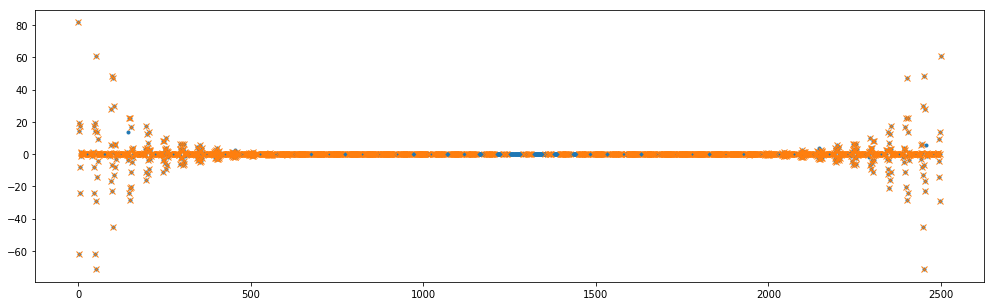

In [21]:
plt.figure(figsize=(17,5))
plt.plot(np.arange(2500), img_fft.reshape(-1).real, '.')
plt.plot(mask_vect_index, Vrobs, 'x')

In [25]:
likelihood=gpflow.likelihoods.Gaussian()
print(Uobs.shape, Vrobs.shape)

(1445, 2) (1445,)


In [28]:
m_real = gpflow.models.VGP(Uobs, Vrobs, kern=K, likelihood=likelihood, num_latent=1)

In [29]:
gpflow.train.ScipyOptimizer().minimize(m_real)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 7002025.207383
  Number of iterations: 1
  Number of functions evaluations: 3


In [30]:
m_imag = gpflow.models.VGP(Uobs, Viobs, kern=K, likelihood=likelihood, num_latent=1)
gpflow.train.ScipyOptimizer().minimize(m_imag)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 6233363.240380
  Number of iterations: 7
  Number of functions evaluations: 11


In [40]:
def plot_gp(x, mu, var, color='k'):
    plt.plot(x, mu, color=color, lw=2)
    plt.plot(x, mu + 2*np.sqrt(var), '--', color=color)
    plt.plot(x, mu - 2*np.sqrt(var), '--', color=color)

def plot(m):
    xtest = np.linspace(0, 50, 50)[:,None]
    line, = plt.plot(mask_vect_index, Vrobs, 'x', mew=2)
    mu, var = m.predict_f()
    plot_gp(xtest, mu, var, line.get_color())

#     line, = plt.plot(mask_vect_index, Viobs, 'x', mew=2)
#     mu, var = m.predict_f(np.hstack((xtest, np.ones_like(xtest))))
#     plot_gp(xtest, mu, var, line.get_color())

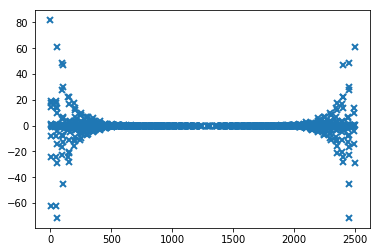

In [41]:
plot(m_real)
